# Quick Start

This guide will walk you through the initial steps to leverage minto. In this section, we will cover four main steps from setting up minto to handling experimental data.

- How to install minto
- Recording experimental data
- Viewing recorded experimental data in a table
- Saving and loading experimental data

## Installation

```bash
pip install minto
```

## Record Experimental Data

With `minto` you can easily record various data generated during experiments.  
In the following example, we will conduct numerical experiments on the time limit dependency of MIP solvers using PySCIPOpt, which is supported by OMMX.
`minto` natively supports OMMX Message, allowing us to smoothly perform numerical experiments through OMMX.

Let's give it a try.

In [1]:
import minto
import ommx_pyscipopt_adapter as scip_ad
from ommx.dataset import miplib2017

In this tutorial, we will pick up an instance from miplib2017 as a benchmark target. We can easily obtain miplib2017 instances using ommx.dataset.

In [2]:
instance_name = "reblock115"
instance = miplib2017(instance_name)

Using the `ommx_pyscipopt_adapter`, we convert ommx.v1.Instance to PySCIPOpt's Model and conduct experiments by varying the limits/time parameter.

The ommx instance and solution can be saved using MINTO's `.log_*` methods. Since we're using a single instance that doesn't change throughout this numerical experiment, we store it in the `experiment` space outside the with block. 
Solutions are saved within the with block (in the `run` space) since they vary for each time limit.

In [3]:
timelimit_list = [0.1, 0.5, 1, 2]

# When auto_saving is True, data is saved automatically whenever Experiment.log_* methods are called.
# Since data is saved progressively, even if an error occurs midway, the data up to that point won't be lost.
experiment = minto.Experiment(
    name="scip_exp",
    auto_saving=True
)

experiment.log_instance(instance_name, instance)
adapter = scip_ad.OMMXPySCIPOptAdapter(instance)
scip_model = adapter.solver_input

for timelimit in timelimit_list:
    with experiment.run():
        experiment.log_parameter("timelimit", timelimit)

        # Solve by SCIP
        scip_model.setParam("limits/time", timelimit)
        scip_model.optimize()
        solution = adapter.decode(scip_model)

        experiment.log_solution("scip", solution)

When converting ommx.Solution to pandas.DataFrame using the `.get_run_table` method, only the main information of the solution is displayed. If you want to access the actual solution objects, you can reference them from `experiment.dataspaces.run_datastores[run_id].solutions`.

In [4]:
runs_table = experiment.get_run_table()
runs_table

solution_scip                                            parameter  \
           objective feasible optimality relaxation start  name timelimit   
run_id                                                                      
0       0.000000e+00     True          0          0  None  scip       0.1   
1      -3.027709e+07     True          0          0  None  scip       0.5   
2      -3.027709e+07     True          0          0  None  scip       1.0   
3      -3.027709e+07     True          0          0  None  scip       2.0   

       metadata               
         run_id elapsed_time  
run_id                        
0             0     0.119688  
1             1     0.399354  
2             2     0.507941  
3             3     1.009734

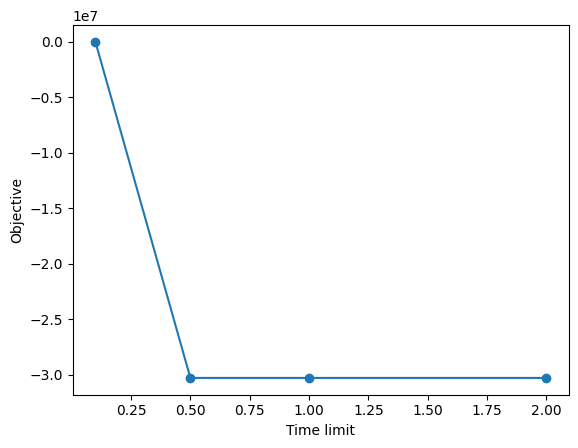

In [5]:
import matplotlib.pyplot as plt

x = runs_table["parameter", "timelimit"]
y = runs_table["solution_scip", "objective"]
plt.plot(x, y, "o-")
plt.xlabel("Time limit")
plt.ylabel("Objective")
plt.show()

## Save and Load Experimental Data

By setting `auto_saving` to `False` in the `Experiment` constructor, you can disable automatic saving. In this case, you can save data at any time using the `Experiment.save` method.  
You can also load saved data using the `Experiment.load_from_dir` method.

In [6]:
# By default, data is saved under .minto_experiments/ directory
experiment.save()

In [7]:
exp2 = minto.Experiment.load_from_dir(
    ".minto_experiments/" + experiment.experiment_name
)

In [8]:
exp2.get_run_table()

solution_scip                                            parameter  \
           objective feasible optimality relaxation start  name timelimit   
run_id                                                                      
0       0.000000e+00     True          0          0  None  scip       0.1   
1      -3.027709e+07     True          0          0  None  scip       0.5   
2      -3.027709e+07     True          0          0  None  scip       1.0   
3      -3.027709e+07     True          0          0  None  scip       2.0   

       metadata               
         run_id elapsed_time  
run_id                        
0             0     0.119688  
1             1     0.399354  
2             2     0.507941  
3             3     1.009734

## Saving and Load to/from OMMX Archive

You can save and load data to/from OMMX Archive using the `Experiment.save_to_ommx_archive` and `Experiment.load_from_ommx_archive` methods.

In [9]:
artifact = experiment.save_as_ommx_archive("scip_experiment.ommx")

In [10]:
exp3 = minto.Experiment.load_from_ommx_archive("scip_experiment.ommx")
exp3.get_run_table()

solution_scip                                            parameter  \
           objective feasible optimality relaxation start  name timelimit   
run_id                                                                      
0       0.000000e+00     True          0          0  None  scip       0.1   
1      -3.027709e+07     True          0          0  None  scip       0.5   
2      -3.027709e+07     True          0          0  None  scip       1.0   
3      -3.027709e+07     True          0          0  None  scip       2.0   

       metadata               
         run_id elapsed_time  
run_id                        
0             0     0.119688  
1             1     0.399354  
2             2     0.507941  
3             3     1.009734

# Summary

In this tutorial, we learned how to use `minto` for managing numerical experiments:

1. **Installation** is straightforward via pip:
    ```bash
    pip install minto
    ```

2. **Recording Experimental Data**
    - Used SCIP solver through OMMX interface
    - Conducted experiments with different time limits (0.1s to 2.0s)
    - Recorded instance data and solution results systematically

3. **Data Management**
    - Automatic saving with `auto_saving=True`
    - Manual saving with `experiment.save()`
    - Data visualization using pandas DataFrame and matplotlib
    - Results showed objective values converging to -2.92e+07

4. **Data Persistence**
    - Local storage in `.minto_experiments/` directory
    - OMMX archive format support.
    - Easy data recovery with `load_from_dir` and `load_from_ommx_archive`

This workflow demonstrates `minto`'s capabilities for structured experimental management in optimization tasks.